## Sentiment Analysis 
**-動機-**  
* 對自然語處理感到興趣啓發，趁這次的自中考的題目，決定研究怎麽去前處理文字的分析。<br>對機器學習來講 前處理是很重要的 所以以下會用各種方法來看結果會如何

**-分析資料介紹-**

* Data Set Name: Sentiment Labelled Sentences Data Set

* Data Set Source:UCI Machine Learning Libarary (https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

* Data Set Info: 這資料包含 yelp，imdb， amazon。留言内容為餐廳評價，電影及產品評價。 1代表Positive， 0代表Negative

**-簡單分析方法介紹-**<br><br>
1）先使用最簡單前處理的方法來，瞭解我的資料以及看資料裏面包含Positive跟Negative的比率<br><br> 2）前處理使用 tag,ngram,Mark Negation等 5種方法來看看結果如何<br><br> 3）使用 SVM, Logistic Regression, SGD的方法來，比較各個模型的準確率<br><br>4) 比較有前處理跟沒有的結果 <br><br> 5）選最好的結果來畫出來confusion matrix更清楚第瞭解分析結果

In [34]:
# 先 import在自然語分類時用到的 library
import os
import numpy as np
import re
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.util import mark_negation
#nltk.download()
#nltk.download('stopwords')
from nltk.corpus import stopwords


#爲了看畫圖 使用 matplotlib.pyplot及可以操控資料樣子的pandas
import matplotlib.pyplot as plt
import pandas as pd

#使用以下的機器學習的分類器
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer

In [36]:
#我要用的三個資料合起來 （amazon ,yelp, amazon）
import shutil
with open('sentiment_analysis.txt','wb') as wfd:
    for f in ['yelp_labelled.txt', 'imdb_labelled.txt', 'amazon_cells_labelled.txt']:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

In [37]:
#把我的資料變成 DataFrame瞭解我資料的樣子及内容
input_file = "sentiment_analysis.txt"
dt = pd.read_csv(input_file,delimiter='\t',header=None)
dt.columns = ['Sentence','Class']
#爲了比較好好操控下面要畫出來Positiveg跟Negative比率的畫圖， 貼上去index列
dt['index'] = dt.index

In [38]:
#看看我的資料的樣子 確認是不是對（amazon：748 ,yelp: 1000, amazon : 1000  記起來 2748個行）
dt.shape

(2748, 3)

## 先瞭解我的資料的樣子

In [46]:
#先看我的資料是否被讀的好
dt.head()

,Sentence,Class,index
0,Wow... Loved this place.,1,0
1,Crust is not good.,0,1
2,Not tasty and the texture was just nasty.,0,2
3,Stopped by during the late May bank holiday of...,1,3
4,The selection on the menu was great and so wer...,1,4


      Class  COUNT
1  Positive   1386
0  Negative   1362


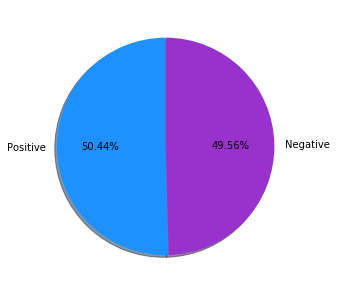

In [86]:
#算Positive跟Negative多少
pd.set_option('display.width', 4000)
pd.set_option('display.max_rows', 1000)
Pos_NegPortion = dt.groupby(by='Class', as_index=False).agg({'index': pd.Series.nunique}).sort_values(by='index', ascending=False)
Pos_NegPortion.columns =['Class', 'COUNT']
#爲了比較能看清楚哪一個是Positive，哪一個是Negative 重新把新的名字給Classl列
Pos_NegPortion['Class']=['Positive','Negative']
print(Pos_NegPortion)
#畫出來資料裏面Positive跟Negative多少，直觀地瞭解我的資料
fig1, ax1 = plt.subplots(figsize=(10,5))
labels = 'Positive', 'Negative'
colors = 'dodgerblue',  'darkorchid'
ax1.pie(Pos_NegPortion['COUNT'],autopct='%1.2f%%',shadow=True, startangle=90, labels=labels, colors=colors)
plt.show()

* 從這結果可以知道，我們的資料的平衡的 是一個好的資料， 可以期待分析出來的結果品質是好的

## 開始主要的工作前處理

In [84]:
#先做出來在下面的前處理會用到的函數
#若是名詞，動詞或形容詞等關鍵文法上重要的單詞十，判斷成Positive tagging
def tag_text(tag):
	if tag.startswith('J'):
		return wn.ADJ
	elif tag.startswith('N'):
		return wn.NOUN
	elif tag.startswith('R'):
		return wn.ADV
	elif tag.startswith('V'):
		return wn.VERB
	elif tag.startswith('I'):
		return wn.VERB
	return None

* 在以下使用的前處理方法是 總共5個：<br>1. 把每個句子的大寫變成小寫<br>2. positive tagging(包含把no跟like除掉)<br>3. 把the除掉<br>4. mark negation<br>5.feature ngram

In [85]:
#先做出來兩個可以放句子的 data變數及 可以放預測好的實際資料的label變數
#（label變數的内容 若是Positive為1,Negative為0）
data = []
label = []
#先把要處理的檔案輸入出來
with open('./sentiment_analysis.txt') as f:
    for i in f:
        #把檔案裏面連續的句子 切開成一個一個的句子
        document = i.split('\t')[0]
        #1. 把每個句子的大寫變成小寫
        document = word_tokenize(document.lower())
        #2. 使用nltk來把句子裏面的 動詞，名詞，形容詞，副詞給標志（tagging）
        tagged = nltk.pos_tag(document)
        #把document的變數做出來以後放處理的文字
        document = []
        for word, tag in tagged:
            wn_tag = tag_text(tag)
            #把no跟like除掉
            if (word == 'no' or word == 'like'):
                wn_tag = wn.ADJ
            # 3. 把the"除掉（語言處理的時候不重要的部分）
            elif wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV, wn.VERB):
                continue
            lemma = stemmer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            document.append(lemma)
        document2 = document.copy()
        # 4. 以下是處理Negative的部分 若是negative，使用mark negation
        document = mark_negation(document)
        for x in range(0,len(document)-1):
            #5.  爲了把文字之間的relation放在考慮裏面 ，使用feature ngram的方法，可以强調文字之間的意思
            #ex ) I am no love >> I_am am_no no_love         
            document.append(document[x]+'_'+document[x+1])
        for l in document2:
            for s in keywords:
                temp = l
                # 以下Mark negation方法的例子 ： I no love >> no love_NEG
                if (l.replace('_NEG','') == s):
                    document.append(temp)
                    document.append(temp)
                    
        #把前處理好的資料合起來
        document = ' '.join(document)
        data.append(document)
        # label column貼在文字的column， 把兩個資料合起來
        label.append(i.split('\t')[1].replace('\n',''))

* 一下使用CountVectorizer跟TfidfTransformer。

In [252]:
#CountVectorizer本身提供ngram的方法，因爲我有自己寫好沒有再使用。
#照著頻率把文字給Vectorize
count_vect = CountVectorizer(lowercase=True, binary=False)
X_train_counts = count_vect.fit_transform(data)

#例如is, be這種單詞 出現的頻率很多 可是不是很重要所以使用Tfidf來評估文字之間的連貫性
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## 開始使用機器學習的Model<br><br>* 看看能不能好好預測Positive跟Negative的句子 *

In [130]:
#把資料切開成Train 跟 Test 
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_counts, label, test_size=0.2, random_state=87)

print("shape = {}".format(X_train_counts.shape))

shape = (3000, 22179)


**<先簡單看看各種方法的結果之後， 下面做出來一個confusion matrix>**

* SVM 

In [131]:
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)
print("Score SVM:", classifier_linear.score(X_test, y_test))

Score SVM: 0.8183333333333334


* SGDClassifier

In [132]:
clf = SGDClassifier(max_iter=1000, tol=1e-3,loss='hinge', penalty='l2',alpha=1e-3, random_state=42)
clf.fit(X_train, y_train)
print("Score SGD:", clf.score(X_test, y_test))

Score SGD: 0.8266666666666667


* logistic Regresstion

In [133]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("Score LR:", classifier.score(X_test, y_test))

Score LR: 0.8333333333333334


## 跟沒有前處理的結果比較<br><br> - 發現反而前處理得比較少的時候結果比較好

In [150]:
with open('./amazon_cells_labelled.txt') as f:
    for i in f:
        document = i.split('\t')[0]
        document = word_tokenize(document.lower())
        document = ' '.join(document)
        data.append(document)
        label.append(i.split('\t')[1].replace('\n',''))
with open('./imdb_labelled.txt') as f:
    for i in f:
        document = i.split('\t')[0]
        document = word_tokenize(document.lower())
        document = ' '.join(document)
        data.append(document)
        label.append(i.split('\t')[1].replace('\n',''))
with open('./yelp_labelled.txt') as f:
    for i in f:
        document = i.split('\t')[0]
        document = word_tokenize(document.lower())
    document =' '.join(document)
    data.append(document)
    label.append(i.split('\t')[1].replace('\n',''))
    
count_vect = CountVectorizer(lowercase=True, binary=False)
X_train_counts = count_vect.fit_transform(data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_counts, label, test_size=0.2, random_state=87)

print("shape = {}".format(X_train_counts.shape))

shape = (7002, 23417)


*----------------------------------------------------------------------------------------------------------------------------------------------------------------------*
* SVM

In [151]:
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)
print("Score SVM:", classifier_linear.score(X_test, y_test))

Score SVM: 0.9350463954318344


* SGDClassifier

In [152]:
clf = SGDClassifier(max_iter=1000, tol=1e-3,loss='hinge', penalty='l2',alpha=1e-3, random_state=42)
clf.fit(X_train, y_train)
print("Score SGD:", clf.score(X_test, y_test))

Score SGD: 0.9172019985724482


* SGDClassifier

In [153]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print("Score LR:", classifier.score(X_test, y_test))

Score LR: 0.9193433261955746


*----------------------------------------------------------------------------------------------------------------------------------------------------------------------*

In [187]:
#爲了做出confusion matrix做 而算出x的預測
xpredict = classifier_linear.predict(X_test)
print(xpredict.shape, X_test.shape)

(1401,) (1401, 23417)


In [236]:
#簡單看看confusion matrix的樣子
from sklearn.metrics import confusion_matrix
print(confusion_matrix(xpredict, y_test))

[[653  40]
 [ 51 657]]


## 畫出來confusion matrix來更清楚的看分析的結果<br><br>選最好的結果 - 沒有前處理的SVM model

In [234]:
#我自己再次修改高手的confusion matrix （source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix）
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "r")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(150,100))

In [207]:
#爲了把結果用confusion matrix 畫出來處理資料
dt = pd.DataFrame(data)
lb = pd.DataFrame(label)
print(dt.shape)
print(lb.shape)
#把label放在df
dt[1]=lb
#把名字給表格的列
dt.columns = ['Sentence','Class']

(7002, 1)
(7002, 1)


,Category,Index
0,1,1
1,0,2


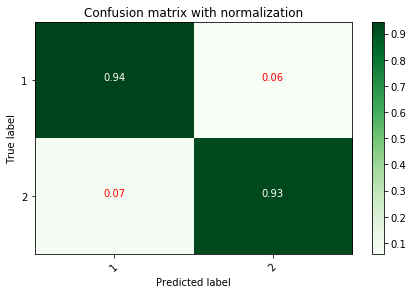

<Figure size 10800x7200 with 0 Axes>

In [244]:
#修改資料的Dataframe
#dt = dt.drop("index", 1)
dt = dt[['Class','Sentence']]
# Compute confusion matrix
classes  = dt['Class'].unique()
classifier_linear_matrix = confusion_matrix(y_test, xpredict,classes) 
np.set_printoptions(precision=2)
class_name = range(1,classes.size+1)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(classifier_linear_matrix, classes=class_name,title='Confusion matrix with normalization',
                                          normalize=True)
class_frame = pd.DataFrame(data=[])
for i in range(0,classes.size):
    class_frame  = class_frame.append([[classes[i],i+1]],ignore_index=True)
class_frame.columns=['Category','Index']
class_frame

## 心得 ：
* 透過這此其中報告的機會，我第一次建造出來自然語言分析的模型。 雖然實驗當中間碰到許多Error， 相對的過程當中，學到的也很多。尤其是現在覺得對操控pandas方面比較有上手。覺得這是對Data Scientist來講是最基本的能力。<br>
* 這次用到的資料本身已經是很平衡， 所以沒有前處理的時候， 還是得到更好的結果。但是，**我知道以後會碰到的資料可能更複雜而且更大或許太小。這時候，真的需要很多的前處理的工作才能提高準確率。** 以後也要使用很多不同的方法來做實驗，讓我對資料分析的視野變得更廣

## Future Work 
* 參加有關自然語言的比賽（kaggle）來提高資料分析的能力 - 以後可以做做看 Author Recognition，Chatbot
* 要自己寫出來這次用到的SVM, Logistic Regression的機器學習函數